In [10]:
from abc import ABC, abstractmethod
import logging
import os
import sys
import tempfile
from glob import glob
import random
import numpy as np
import torch
import torch.distributed as dist
from PIL import Image
import matplotlib.pyplot as plt

import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch, DataLoader, partition_dataset, CacheDataset
from monai.apps.nuclick.transforms import SplitLabelMined
from monai.apps import CrossValidation
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityd,
    RandTorchVisiond,
    ScaleIntensityRangeD,
    SelectItemsd,
    SaveImaged,
    OneOf,
    MedianSmoothd,
    AsDiscreted,
    CastToTyped,
    ComputeHoVerMapsd,
    RandGaussianNoised,
    RandFlipd,
    RandAffined,
    RandGaussianSmoothd,
    CenterSpatialCropd,
)
from monai.handlers import (
    MeanDice,
    CheckpointSaver,
    LrScheduleHandler,
    StatsHandler,
    TensorBoardStatsHandler,
    ValidationHandler,
    from_engine,
)
from monai.visualize import plot_2d_or_3d_image
from monai.utils import set_determinism
import wandb 

In [11]:
datadir = '/data/KPIs24/KPIs24 Training Data/Task1_patch_level/data/'

In [12]:
images = sorted(glob(os.path.join(datadir, "**/*img.jpg"), recursive = True))[0:1]
labels = sorted(glob(os.path.join(datadir, "**/*mask.jpg"), recursive = True))[0:1]

In [13]:
images

['/data/KPIs24/KPIs24 Training Data/Task1_patch_level/data/56Nx/12_116/img/56Nx_12_116_108_13312_5120_img.jpg',
 '/data/KPIs24/KPIs24 Training Data/Task1_patch_level/data/56Nx/12_116/img/56Nx_12_116_109_14336_5120_img.jpg',
 '/data/KPIs24/KPIs24 Training Data/Task1_patch_level/data/56Nx/12_116/img/56Nx_12_116_116_2048_6144_img.jpg',
 '/data/KPIs24/KPIs24 Training Data/Task1_patch_level/data/56Nx/12_116/img/56Nx_12_116_117_3072_6144_img.jpg',
 '/data/KPIs24/KPIs24 Training Data/Task1_patch_level/data/56Nx/12_116/img/56Nx_12_116_118_4096_6144_img.jpg',
 '/data/KPIs24/KPIs24 Training Data/Task1_patch_level/data/56Nx/12_116/img/56Nx_12_116_120_6144_6144_img.jpg',
 '/data/KPIs24/KPIs24 Training Data/Task1_patch_level/data/56Nx/12_116/img/56Nx_12_116_122_8192_6144_img.jpg',
 '/data/KPIs24/KPIs24 Training Data/Task1_patch_level/data/56Nx/12_116/img/56Nx_12_116_123_9216_6144_img.jpg',
 '/data/KPIs24/KPIs24 Training Data/Task1_patch_level/data/56Nx/12_116/img/56Nx_12_116_124_10240_6144_img.jpg'

In [15]:
train_data = [{'img': img, 'label': label} for img, label in zip(images, labels)]

In [17]:
def show_image(image, label, points=None):
    print(f"Image: {image.shape}; Label: {label.shape}")

    if image.shape[0] == 3:
        image = np.moveaxis(image, 0, 2)
        label = np.moveaxis(label, 0, 2)

    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap="gray")

    if label is not None:
        masked = np.ma.masked_where(label == 0, label)
        plt.imshow(masked, "jet", interpolation="none", alpha=0.5)

    plt.colorbar()

    if label is not None:
        plt.subplot(1, 2, 2)
        plt.title("label")
        plt.imshow(label > 0)
        plt.colorbar()
    # plt.show()

In [ ]:
train_transforms = Compose(
        [
        LoadImaged(keys=["img", "label"], dtype=torch.uint8),
        EnsureChannelFirstd(keys=["img"], channel_dim=-1),
        EnsureChannelFirstd(keys=["label"], channel_dim='no_channel'),
        SplitLabelMined(keys="label"),
        ScaleIntensityRangeD(keys=("img", "label"), a_min=0.0, a_max=255.0, b_min=0, b_max=1.0),    
        SelectItemsd(keys=("img", "label")),
        ]
    )

for i in range(1):
    data = train_transforms(train_data[i])
    plt.figure()
    plt.imshow(data['label'].squeeze(), cmap = plt.cm.gray)
    # plt.figure()
    # plt.imshow(data['others'].squeeze(), cmap='jet')
    # plt.colorbar()

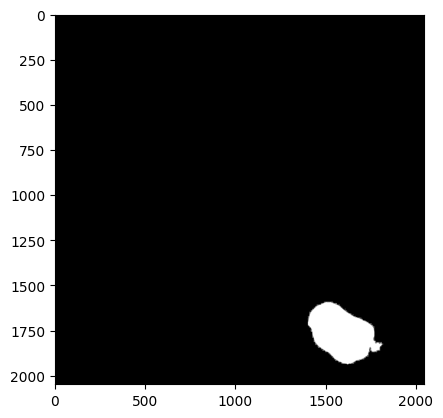

In [25]:
train_transforms = Compose(
        [
        LoadImaged(keys=["img", "label"], dtype=torch.uint8),
        EnsureChannelFirstd(keys=["img"], channel_dim=-1),
        EnsureChannelFirstd(keys=["label"], channel_dim='no_channel'),
        SplitLabelMined(keys="label"),
        RandCropByPosNegLabeld(
            keys=["img", "label"], label_key="label", spatial_size= cfg['preprocessing']['roi_size'], pos=3, neg=1, num_samples=4
        ),
        ScaleIntensityRangeD(keys=("img", "label"), a_min=0.0, a_max=255.0, b_min=0, b_max=1.0),    
        SelectItemsd(keys=("img", "label")),
        ]
    )

for i in range(1):
    data = train_transforms(train_data[i])
    plt.figure()
    plt.imshow(data['label'].squeeze(), cmap = plt.cm.gray)
    # plt.figure()
    # plt.imshow(data['others'].squeeze(), cmap='jet')
    # plt.colorbar()